## 01 Import modules

In [2]:
import pandas as pd
import json
import os
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import pearsonr

#### [Opt] Vars

In [2]:
#pd.set_option('display.max_columns', 50)
PATH = r'/run/media/raphi/F6A8C18DA8C14CB5/Users/Raphael/Documents/Universität/Master/WS 22-23/Digital Humanities/Korpus/formats/internal'
data_list = []

#### [Opt] Funcs

In [3]:
def set_dtypes(df):
    df['id'] = df['id'].astype('Int32')
    df['mbti_profile'] = df['mbti_profile'].astype('string')
    df['contributor_create_date'] = df['contributor_create_date'].astype('string')
    df['is_active'] = df['is_active'].astype('bool')
    df['is_approved'] = df['is_approved'].astype('bool')
    df['mbti_type'] = df['mbti_type'].astype('category')
    df['watch_count'] = df['watch_count'].astype('Int32')
    df['comment_count'] = df['comment_count'].astype('Int32')
    df['vote_count_mbti'] = df['vote_count_mbti'].astype('Int32')
    df['total_vote_counts'] = df['total_vote_counts'].astype('Int32')
    df['cat_id'] = df['cat_id'].astype('Int8')
    df['category'] = df['category'].astype('category')
    df['sub_cat_id'] = df['sub_cat_id'].astype('Int32')
    df['subcategory'] = df['subcategory'].astype('category')
    df['functions'] = df['functions'].astype('string')
    df['category_is_fictional'] = df['category_is_fictional'].astype('bool')
    return df

#### [Opt] Read data from JSONs

In [ ]:
ct = 0
for file in os.listdir(PATH):
        if (ct % 10000) == 0:
                print(f'{ct} file done')
        if file.endswith(".json"):
                with open(rf'{PATH}/{file}') as f:
                        data = json.load(f)
                data_list.append(data)
                ct += 1

#### [Opt] Create Dataframe

In [3]:
dataframe = pd.DataFrame(data_list)
dataframe['mbti_type']= dataframe.mbti_type.str.split(' ').str[0]
dataframe = set_dtypes(dataframe)

NameError: name 'data_list' is not defined

#### [Opt] Store Dataframe with Feather
- Write: 0.783s
- Read: 0.583s
- Size: 13MB

In [4]:
dataframe.to_feather('complete.feather')

NameError: name 'dataframe' is not defined

## 02 Load Data from Feather file

In [5]:
dataframe=pd.read_feather('complete.feather')

## 03 Clear Data
518484 datapoints

In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518484 entries, 0 to 518483
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       518484 non-null  Int32   
 1   mbti_profile             518484 non-null  string  
 2   contributor_create_date  518484 non-null  string  
 3   is_active                518484 non-null  bool    
 4   is_approved              518484 non-null  bool    
 5   mbti_type                518484 non-null  category
 6   watch_count              518484 non-null  Int32   
 7   comment_count            518484 non-null  Int32   
 8   vote_count_mbti          518484 non-null  Int32   
 9   total_vote_counts        518484 non-null  Int32   
 10  cat_id                   518484 non-null  Int8    
 11  category                 518484 non-null  category
 12  sub_cat_id               518484 non-null  Int32   
 13  subcategory              518484 non-null  ca

### 03.1 Reduce to fictional categories
433 150 datapoint remaining

In [7]:
fictional_df = dataframe.query("category_is_fictional == True").copy()

fictional_df = fictional_df.query("category not in ['Music', 'Archetypes', 'Interests', 'Settings', 'Plots', 'Franchises', 'Theories', 'Polls (If you...)', 'Your Experience', 'Type Combo (Your Type)', 'Ask PDB', 'PDB Community']").copy()

### 03.2 Remove entries with small amount of votes
Threshhold "5":\
218 270 datapoints remaining

In [8]:
THRESHHOLD = 5
reduced_df = fictional_df.query(f"total_vote_counts >= {THRESHHOLD}").copy()

### 03.2 Remove entries where mbti_type is uncertain (i.e. contains char 'x')

206 390 datapoints remaining

In [9]:
rows_with_x = reduced_df[reduced_df.mbti_type.str.contains('X',case=False)].copy()
reduced_df = pd.concat([reduced_df, rows_with_x])
reduced_df = reduced_df.drop_duplicates('id', keep=False).copy()

## 04 Analysis

### 4.1 Overall Data
206 390 datapoints

In [11]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165694 entries, 1 to 518479
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       165694 non-null  Int32   
 1   mbti_profile             165694 non-null  string  
 2   contributor_create_date  165694 non-null  string  
 3   is_active                165694 non-null  bool    
 4   is_approved              165694 non-null  bool    
 5   mbti_type                165694 non-null  category
 6   watch_count              165694 non-null  Int32   
 7   comment_count            165694 non-null  Int32   
 8   vote_count_mbti          165694 non-null  Int32   
 9   total_vote_counts        165694 non-null  Int32   
 10  cat_id                   165694 non-null  Int8    
 11  category                 165694 non-null  category
 12  sub_cat_id               165694 non-null  Int32   
 13  subcategory              165694 non-null  categor

### 4.2 Data per Category
Fictional Categories only:
- Anime & Manga            : 55235
- Cartoons                 : 29266
- Comics                   : 3345
- Gaming                   : 79745
- Literature               : 37105
- Movies                   : 51230
- Superheroes              : 4958
- Television               : 78084
- Theatre                  : 3104
- Web Comics               : 18469

In [12]:
fictional_df.groupby('category', observed=True)['id'].count()

category
Anime & Manga    55235
Cartoons         29266
Comics            3345
Gaming           79745
Literature       37105
Movies           51230
Superheroes       4958
Television       78084
Theatre           3104
Web Comics       18469
Name: id, dtype: int64

### 4.3 Highest occurences of mbti_types in corpus

<Axes: xlabel='mbti_type'>

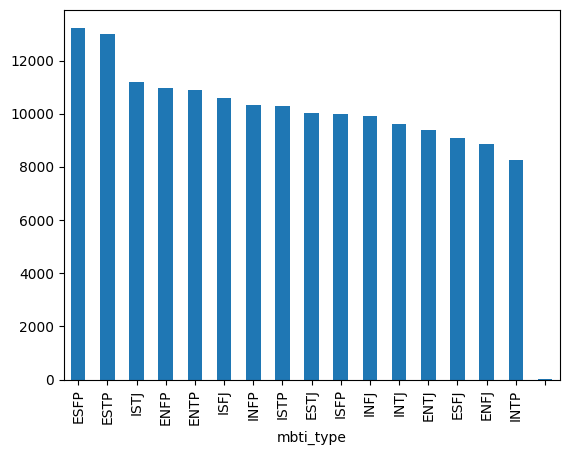

In [21]:
reduced_df.groupby('mbti_type', observed=True)['id']\
    .count()\
    .sort_values(ascending=False)\
    .plot.bar()

### 4.4 Highest occurences of mbti_types by category

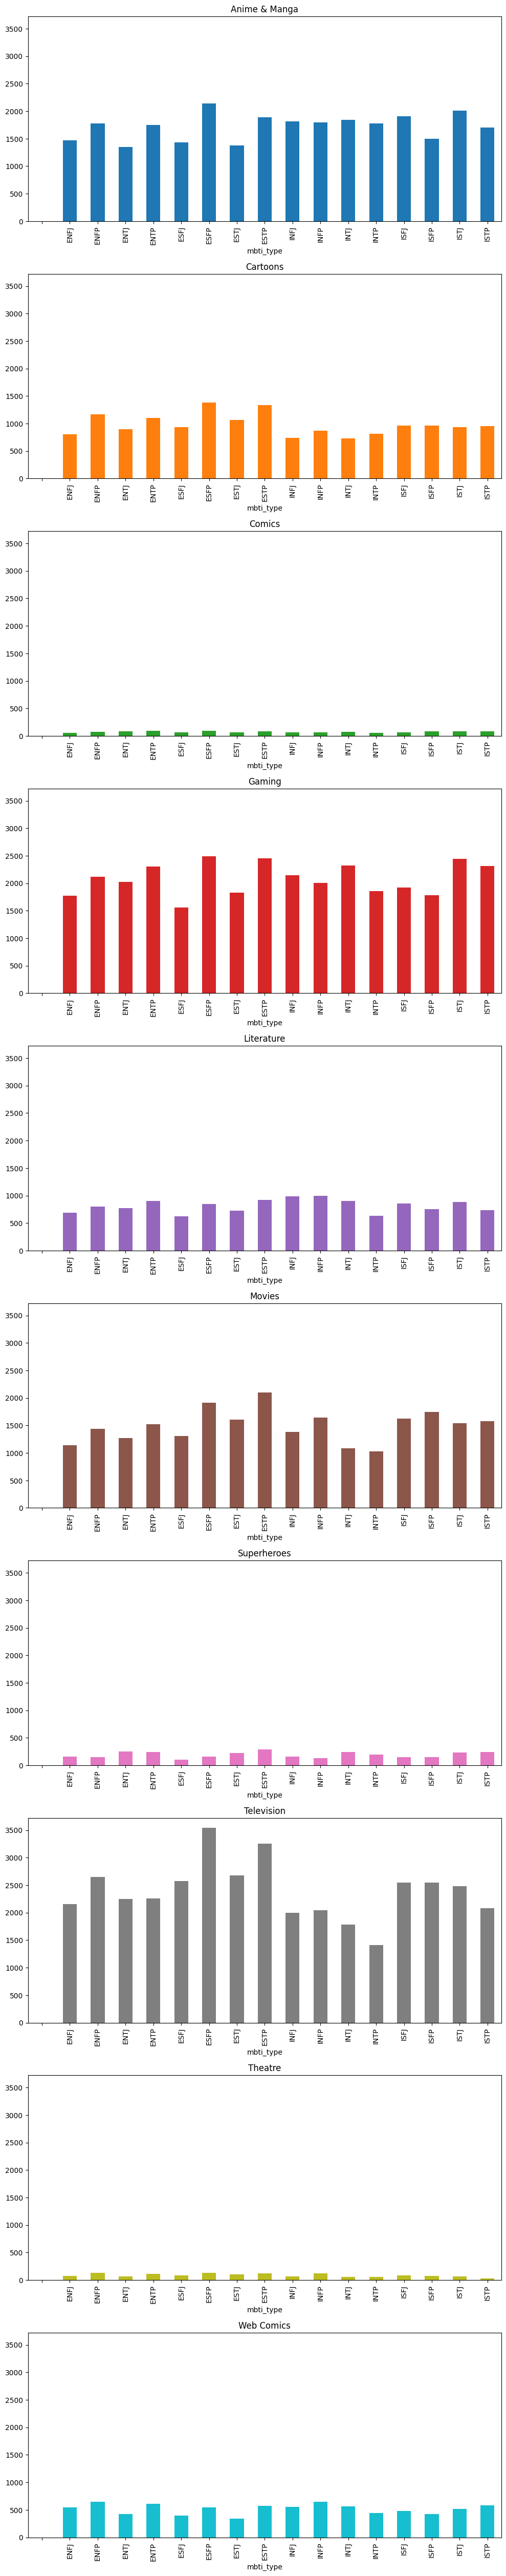

In [22]:
pivot = reduced_df.pivot_table(\
    index=['mbti_type'],\
    columns=['category'],\
    values='id',\
    aggfunc={'id': 'count'},\
    observed=True)

pivot.plot(\
    subplots=True,\
    sharey=True,\
    #grid=True,\
    layout=(20,1),\
    figsize=(10,100),\
    kind='bar',\
    sharex=False,\
    legend=False)

plt.tight_layout()

### 4.5 Number of subcategories

In [23]:
num_unique_subcategories = len(reduced_df['subcategory'].dropna().unique())

print('Number of unique subcategories:', num_unique_subcategories)

Number of unique subcategories: 20696


### 4.6 Twenty subcategories with the highest amount of MBTI votes

In [26]:
subcategory_votes = reduced_df.groupby('subcategory')['vote_count_mbti'].sum()

top_subcategories = subcategory_votes.sort_values(ascending=False).head(20)

print('Top 20 subcategories by collective vote_count_mbti:')
print(top_subcategories)

Top 20 subcategories by collective vote_count_mbti:
subcategory
Genshin Impact                          91875
Naruto Shippūden                        49579
Boku no Hero Academia                   47470
Shingeki no Kyojin                      47256
MCU: The Heroes                         38742
Bungou Stray Dogs                       36641
Harry Potter / Wizarding World Films    33790
Kimetsu no Yaiba                        33402
Stranger Things                         31955
Hunter X Hunter                         31500
Haikyuu!!                               31367
JoJo no Kimyou na Bouken                29654
Death Note                              29323
Game of Thrones (2011)                  27582
Avatar: The Last Airbender (2005)       27278
Jujutsu Kaisen                          26635
Tokyo Revengers                         26606
Chainsaw Man                            23765
One Piece                               22992
Star Wars                               21635
Name: vote_count

#### 4.6.1 MBTI Type distribution 

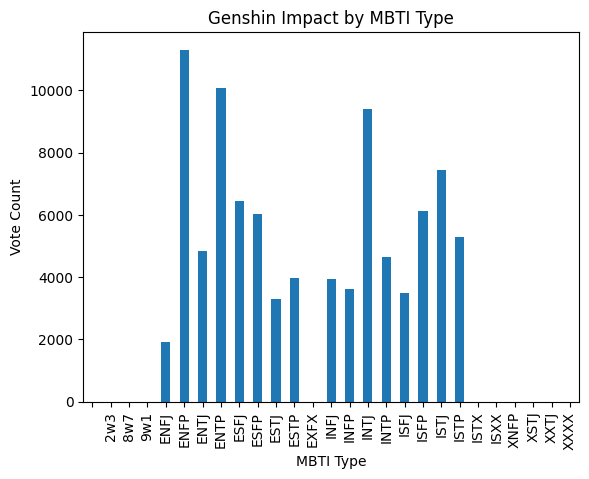

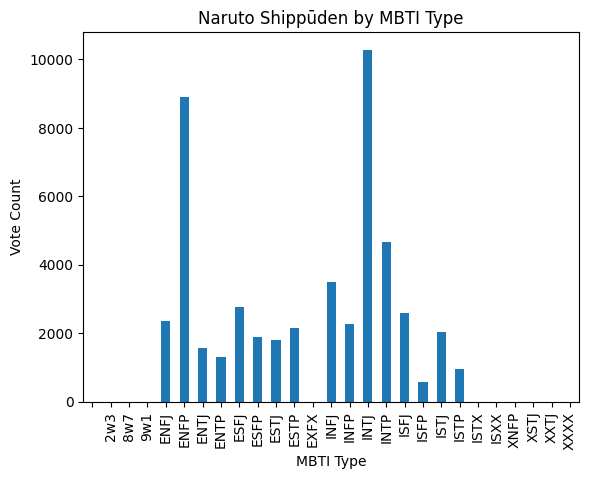

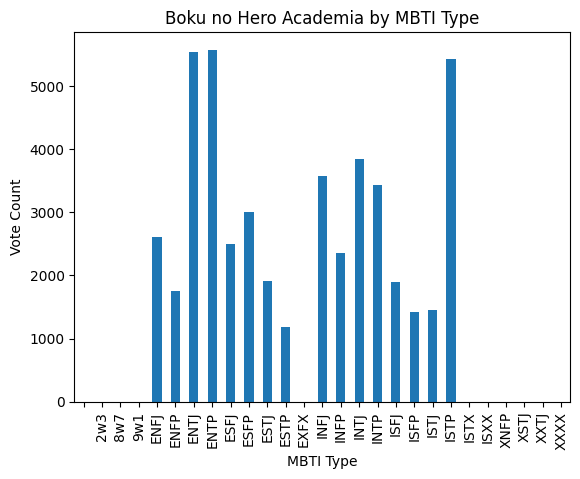

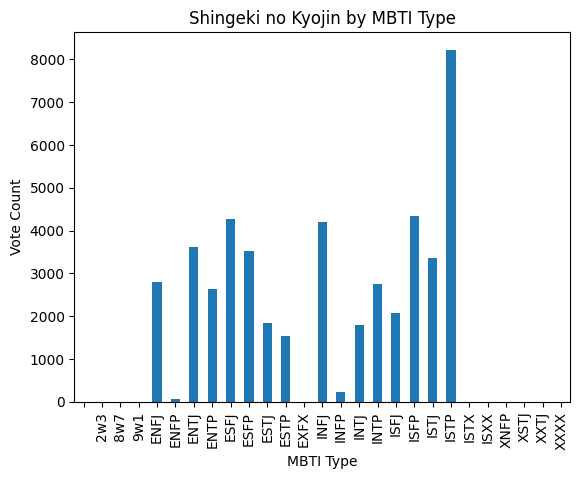

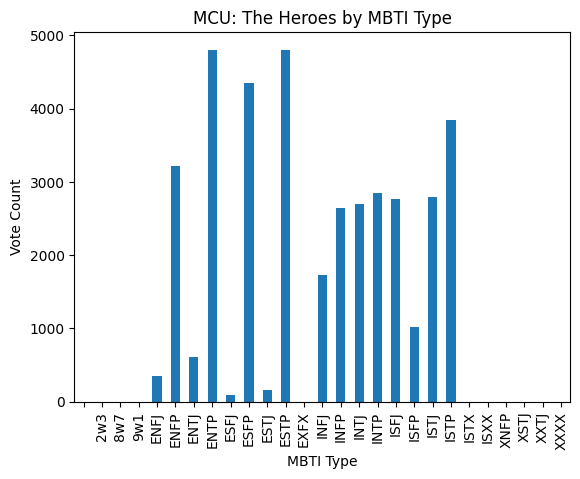

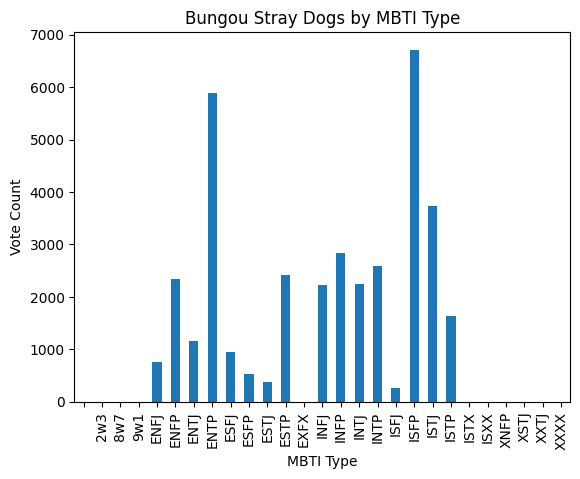

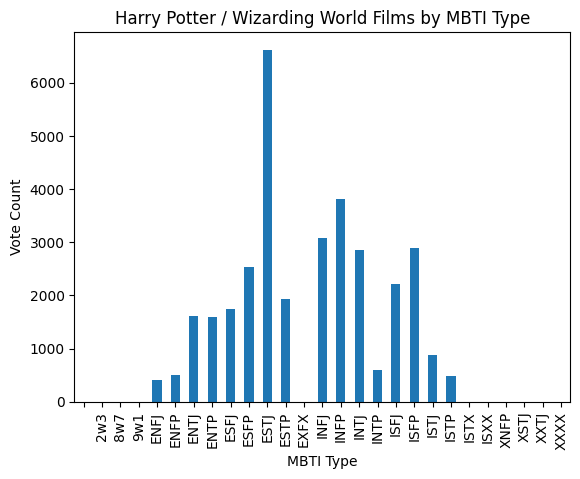

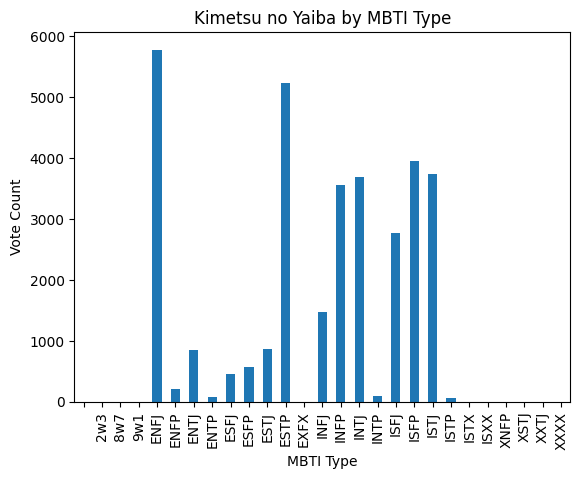

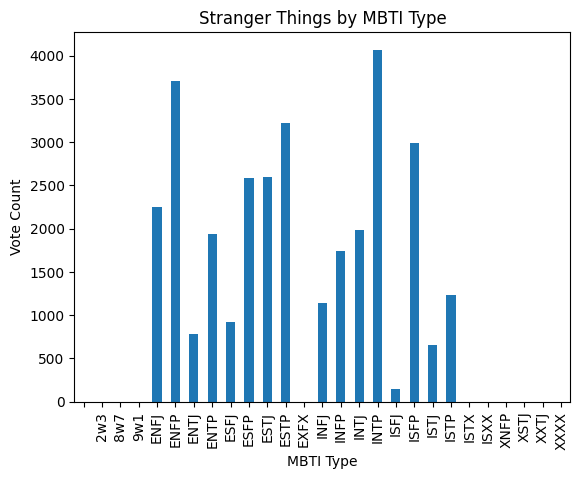

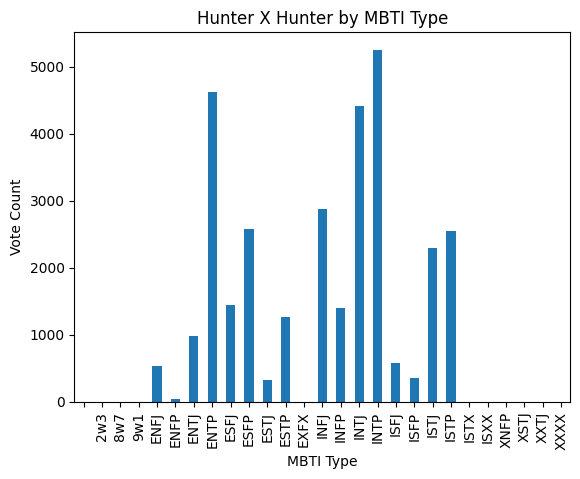

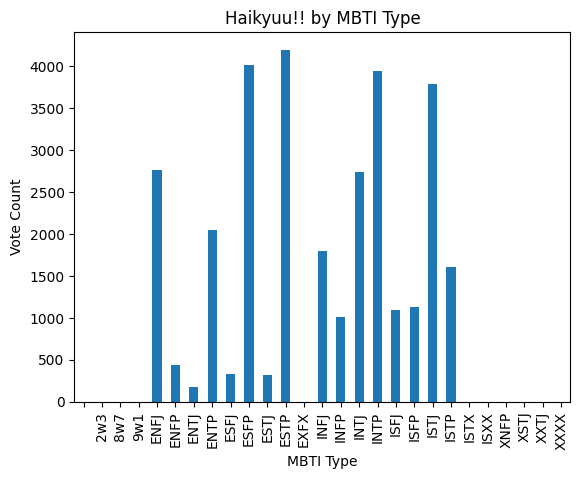

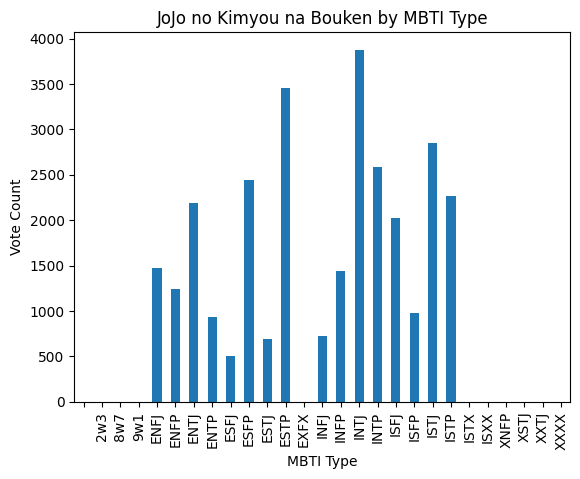

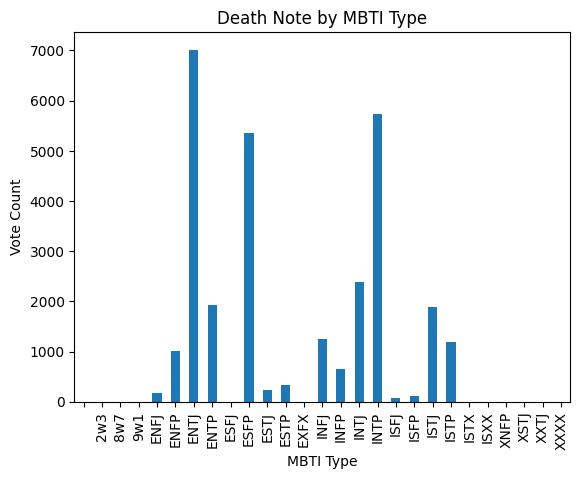

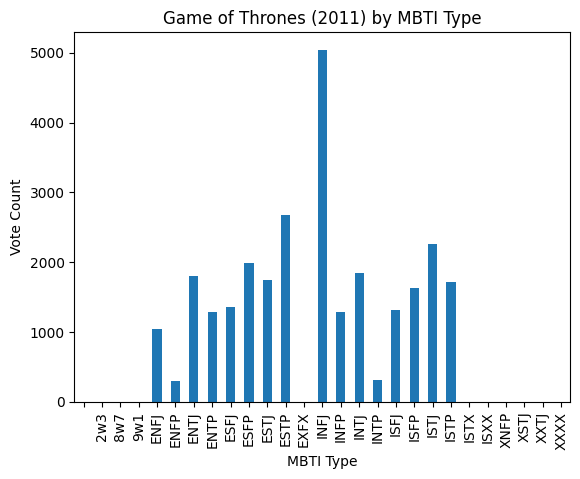

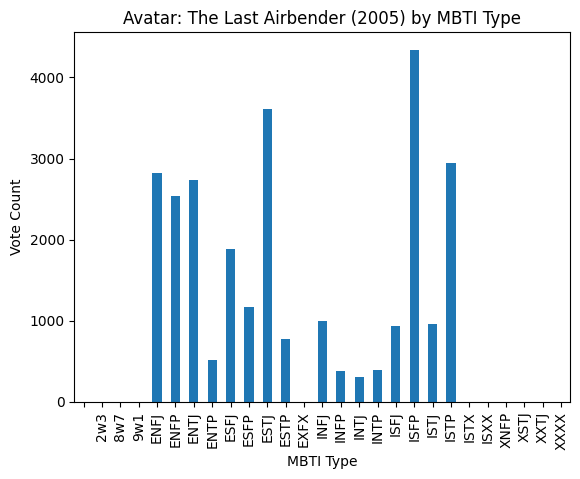

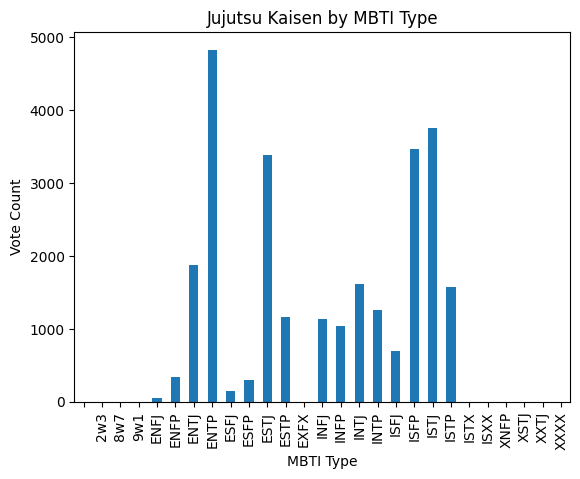

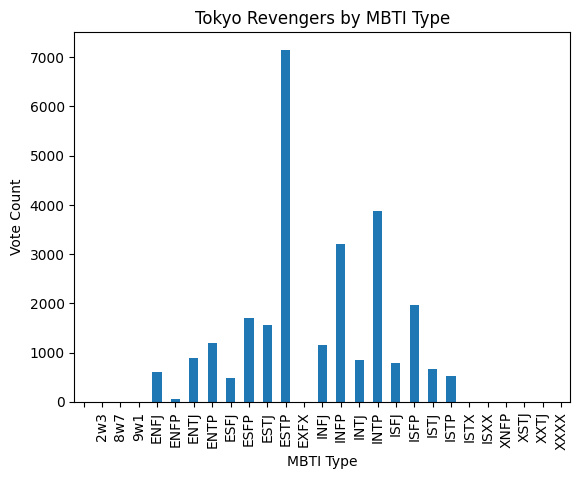

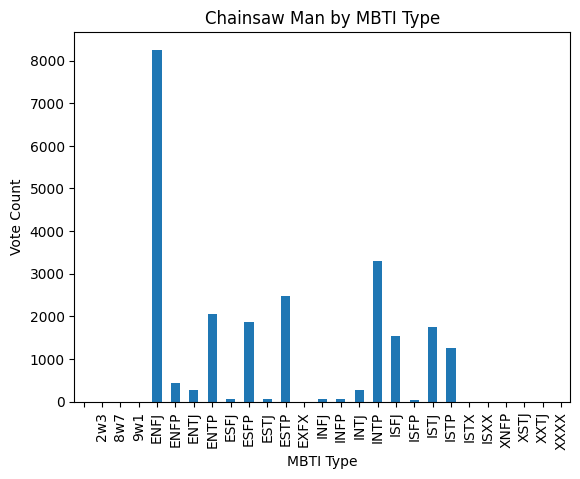

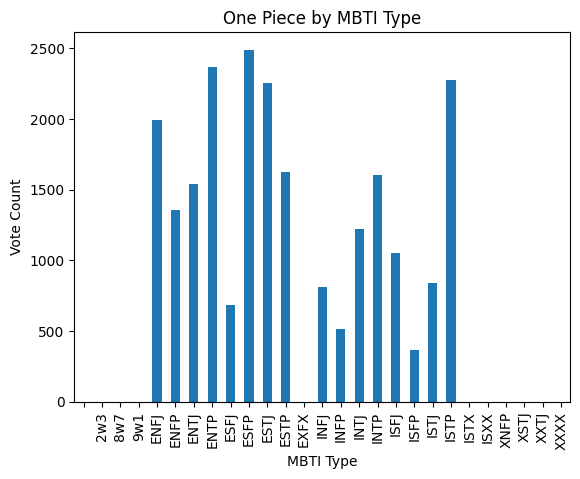

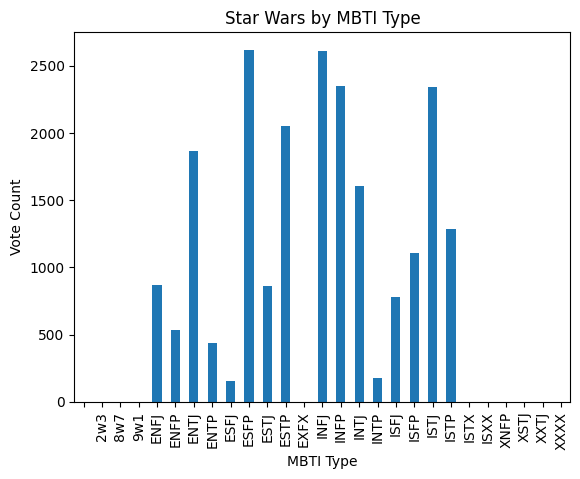

In [30]:
subcategory_votes = reduced_df.groupby('subcategory')['vote_count_mbti'].sum()

top_subcategories = subcategory_votes.sort_values(ascending=False).head(20)

for subcategory in top_subcategories.index:
    subcategory_df = reduced_df[reduced_df['subcategory'] == subcategory]
    mbti_votes = subcategory_df.groupby('mbti_type')['vote_count_mbti'].sum()
    mbti_votes.plot(kind='bar', title=f"{subcategory} by MBTI Type", xlabel='MBTI Type', ylabel='Vote Count')
    
    plt.show()

### 4.7 Distribution of MBTI votes

In [31]:
mean_vote_count = reduced_df['vote_count_mbti'].mean()
median_vote_count = reduced_df['vote_count_mbti'].median()

print(f"Average vote count: {mean_vote_count}")
print(f"Median vote count: {median_vote_count}")

Average vote count: 29.325642449334314
Median vote count: 7.0


### 4.9 Popularity and MBTI type correlation

Correlation coefficient: 0.000655
p-value: 0.789641


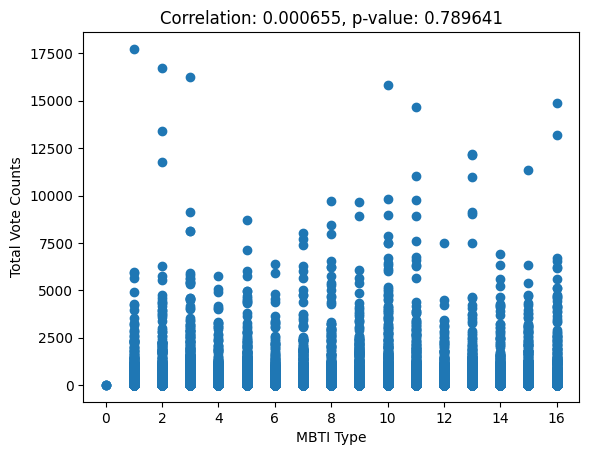

In [45]:

# Encode the 'mbti_type' column into numeric labels
enc = OrdinalEncoder(dtype=int)
reduced_df['mbti_type'] = enc.fit_transform(reduced_df[['mbti_type']])

reduced_df = reduced_df[['total_vote_counts', 'mbti_type']]

# Impute missing values in the 'total_vote_counts' column with the mean
imputer = SimpleImputer(strategy='mean')
reduced_df['total_vote_counts'] = imputer.fit_transform(reduced_df[['total_vote_counts']])

reduced_df['total_vote_counts'] = pd.to_numeric(reduced_df['total_vote_counts'])

# Drop any rows with missing values
reduced_df.dropna(inplace=True)

# Compute the correlation coefficient between total_vote_counts and mbti_type
corr, pval = pearsonr(reduced_df['total_vote_counts'], reduced_df['mbti_type'])

print(f'Correlation coefficient: {corr:.6f}')
print(f'p-value: {pval:.6f}')

plt.scatter(reduced_df['mbti_type'], reduced_df['total_vote_counts'])
plt.xlabel('MBTI Type')
plt.ylabel('Total Vote Counts')
plt.title(f'Correlation: {corr:.6f}, p-value: {pval:.6f}')
plt.show()

### 4.8 Differences between Movies, Books, etc.

In [10]:
# Get the subcategories that occur in more than one category
subcat_counts = reduced_df.groupby('subcategory')['category'].nunique().reset_index()
subcat_counts = subcat_counts[subcat_counts['category'] > 1]

# Get the top 20 subcategories based on the collective vote count
subcat_votes = reduced_df.groupby('subcategory')['vote_count_mbti'].sum().reset_index()
subcat_votes = subcat_votes[subcat_votes['subcategory'].isin(subcat_counts['subcategory'])]
subcat_votes = subcat_votes.sort_values(by='vote_count_mbti', ascending=False).head(20)

# Merge the two dataframes to get the final list of subcategories
subcat_merge = pd.merge(subcat_counts, subcat_votes, on='subcategory')

print(subcat_merge)

                                          subcategory  category   
0                                               Chess         2  \
1                     Danganronpa V3: Killing Harmony         2   
2                                        Frankenstein         2   
3                           Higurashi no Naku Koro ni         2   
4                                     Life is Strange         2   
5                                        Little Women         2   
6   Magia Record: Puella Magi Madoka Magica Side S...         2   
7                                             Moomins         2   
8                                             My Name         2   
9                                  Our Beloved Summer         2   
10                                           Overlord         2   
11                                      Resident Evil         2   
12                            Serial Experiments Lain         2   
13                                  The Addams Family         